In [1]:
#read train data and label data 
import pandas as pd
train_data = pd.read_csv('../preprocessed_data/selected_train_X.csv')
train_label = pd.read_csv('../original_data/train_y.csv')
print(train_data.shape)
print(train_label.shape)

c:\Users\Steven\anaconda3\envs\datamining\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\Steven\anaconda3\envs\datamining\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
c:\Users\Steven\anaconda3\envs\datamining\lib\site-packages\numpy\.libs\libopenblas64__v0.3.23-246-g3d31191b-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


(44939, 62)
(44939, 1)


In [2]:
def plot_balance(X_resampled, y_resampled):
    import pandas as pd
    from imblearn.over_sampling import KMeansSMOTE
    from sklearn.decomposition import PCA
    import matplotlib.pyplot as plt
    import seaborn as sns




    # 使用PCA进行降维
    pca = PCA(n_components=2)
    X_resampled_pca = pca.fit_transform(X_resampled)

    # 将降维后的数据和标签合并
    resampled_df = pd.DataFrame(data=X_resampled_pca, columns=['PC1', 'PC2'])
    resampled_df['has_died'] = y_resampled

    # 绘制散点图
    plt.figure(figsize=(10, 8))
    sns.scatterplot(x='PC1', y='PC2', hue='has_died', data=resampled_df, palette='viridis')
    plt.title('Scatter Plot of Balanced Data with Labels')
    plt.xlabel('Principal Component 1 (PC1)')
    plt.ylabel('Principal Component 2 (PC2)')
    plt.legend()
    plt.show()

c:\Users\Steven\anaconda3\envs\datamining\lib\site-packages\scipy\__init__.py:132: UserWarning: A NumPy version >=1.21.6 and <1.28.0 is required for this version of SciPy (detected version 1.21.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


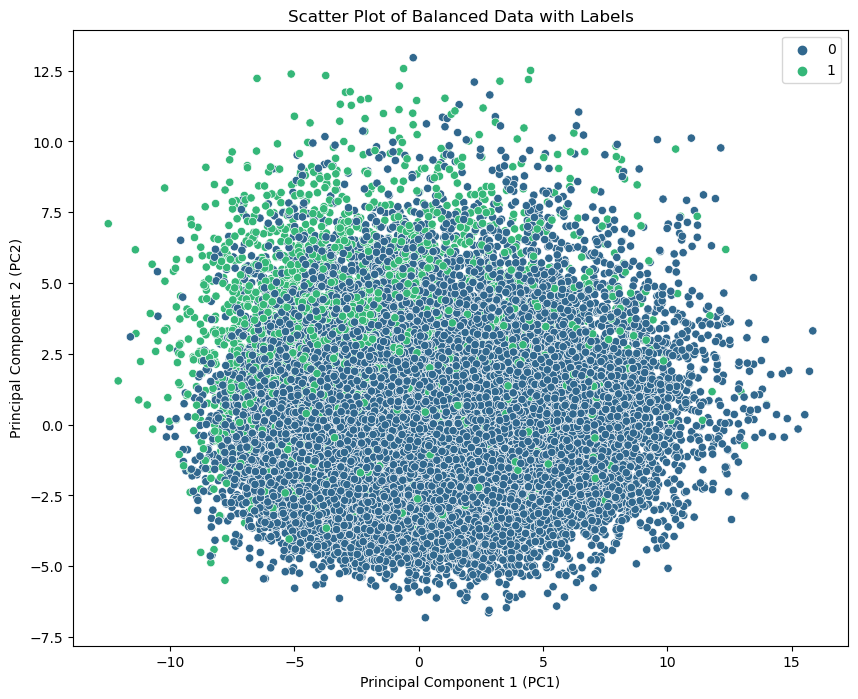

In [3]:
plot_balance(train_data, train_label)

In [28]:
#outlier detection
from sklearn.ensemble import IsolationForest

clf = IsolationForest(random_state=42 ,contamination=0.0003)  
print("Original data shape: ", train_data.shape)
outliers = clf.fit_predict(train_data)
train_data = train_data[outliers == 1]
train_label = train_label[outliers == 1]
print("Clean data shape: ", train_data.shape)

Original data shape:  (44939, 62)
Clean data shape:  (44925, 62)


In [4]:
start_value = 0.1
end_value = 0.99
gap = 0.005

# Initialize an empty list to store the generated values
threshold_list = []

# Generate values using a loop
current_value = start_value
while current_value <= end_value:
    threshold_list.append(current_value)
    current_value += gap

# Print the generated list
print(len(threshold_list))

178


In [5]:
import pandas as pd
from sklearn.model_selection import KFold
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, f1_score, recall_score, precision_score
import numpy as np
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import ADASYN, BorderlineSMOTE
from imblearn.combine import SMOTETomek, SMOTEENN
from collections import Counter
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
# # 使用K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 初始化模型
model = XGBClassifier(n_estimators=2200, random_state=42, eta=0.01, max_depth=17, subsample=0.8, colsample_bytree=0.8, gamma=0.1, scale_pos_weight=10)
# 初始化指標列表
auroc_scores = dict()
f1_scores = dict()
recall_scores = dict()
precision_scores = dict()
tomelink = TomekLinks()
# 進行K-Fold Cross-Validation
count = 0
for train_index, val_index in kf.split(train_data):
    print(f"{count} fold")
    count += 1
    X_train, X_val = train_data.iloc[train_index], train_data.iloc[val_index]
    y_train, y_val = train_label.iloc[train_index]['has_died'], train_label.iloc[val_index]['has_died']

    X_resampled, y_resampled = tomelink.fit_resample(X_train, y_train)
    # 訓練模型
    model.fit(X_resampled, y_resampled)
    # 預測概率
    y_pred_prob = model.predict_proba(X_val)[:, 1]
    
    for threshold in threshold_list:
        # 計算AUROC和F1-Score
        auroc = roc_auc_score(y_val, y_pred_prob)
        f1 = f1_score(y_val, (y_pred_prob > threshold).astype(int), average='macro')
        # calculate recall and precision
        recall = recall_score(y_val, (y_pred_prob > threshold).astype(int), average='macro')
        precision = precision_score(y_val, (y_pred_prob > threshold).astype(int), average='macro', zero_division=0)

        # 將得分加入列表
        auroc_scores.setdefault(threshold, []).append(auroc)
        f1_scores.setdefault(threshold, []).append(f1)
        recall_scores.setdefault(threshold, []).append(recall)
        precision_scores.setdefault(threshold, []).append(precision)


# # 計算平均AUROC和Macro F1-Score
average_auroc = {key: np.mean(value) for key, value in auroc_scores.items()}
average_f1 = {key: np.mean(value) for key, value in f1_scores.items()}
average_recall = {key: np.mean(value) for key, value in recall_scores.items()}  
average_precision = {key: np.mean(value) for key, value in precision_scores.items()}

# 打印結果
print(f'Average AUROC: {average_auroc}')
print(f'Average Macro F1-Score: {average_f1}')
print(f'Average Recall: {average_recall}')
print(f'Average Precision: {average_precision}')


0 fold
1 fold
2 fold
3 fold
4 fold
Average AUROC: {0.1: 0.8848518245330528, 0.10500000000000001: 0.8848518245330528, 0.11000000000000001: 0.8848518245330528, 0.11500000000000002: 0.8848518245330528, 0.12000000000000002: 0.8848518245330528, 0.12500000000000003: 0.8848518245330528, 0.13000000000000003: 0.8848518245330528, 0.13500000000000004: 0.8848518245330528, 0.14000000000000004: 0.8848518245330528, 0.14500000000000005: 0.8848518245330528, 0.15000000000000005: 0.8848518245330528, 0.15500000000000005: 0.8848518245330528, 0.16000000000000006: 0.8848518245330528, 0.16500000000000006: 0.8848518245330528, 0.17000000000000007: 0.8848518245330528, 0.17500000000000007: 0.8848518245330528, 0.18000000000000008: 0.8848518245330528, 0.18500000000000008: 0.8848518245330528, 0.19000000000000009: 0.8848518245330528, 0.1950000000000001: 0.8848518245330528, 0.2000000000000001: 0.8848518245330528, 0.2050000000000001: 0.8848518245330528, 0.2100000000000001: 0.8848518245330528, 0.2150000000000001: 0.8848

In [32]:
#find best threshold that has highest f1 score in each threshold and print the best threshold and its f1 score
best_threshold = max(average_f1, key=average_f1.get)
best_f1 = average_f1[best_threshold]
best_AUROC = average_auroc[best_threshold]
print(f'The best result is with Average AUROC {best_AUROC} and macro F1-Score: {best_f1}')
print(f'Best threshold: {best_threshold} with Average AUROC {best_AUROC} macro F1-Score: {best_f1}')

The best result is with Average AUROC 0.8848518245330528 and macro F1-Score: 0.7290485148960764
Best threshold: 0.2150000000000001 with Average AUROC 0.8848518245330528 macro F1-Score: 0.7290485148960764


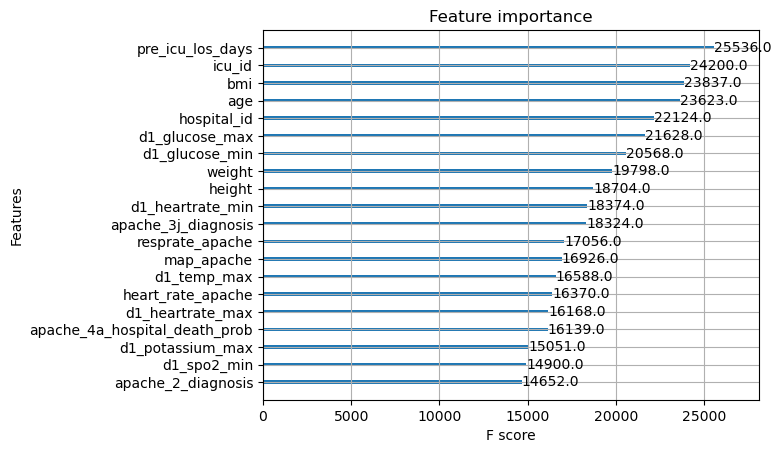

In [7]:
import xgboost as xgb
import matplotlib.pyplot as plt


# 使用 plot_importance 顯示特徵重要性
xgb.plot_importance(model, importance_type='weight', max_num_features=20)  # 你可以選擇 'weight', 'gain', 'cover' 等作為 importance_type
plt.show()


In [34]:
test_data = pd.read_csv('../preprocessed_data/selected_test_X.csv')
sample_csv = pd.read_csv('../original_data/sample_submission.csv')

test_data = test_data
test_pred_prob = model.predict_proba(test_data)[:, 1]
test_pred = (test_pred_prob > best_threshold).astype(int)
test_pred = pd.DataFrame(test_pred)
test_pred.columns = ['has_died']
#combine test_pred and sample_csv
sample_csv["pred"] = test_pred["has_died"]
print(sample_csv)
sample_csv.to_csv('../pred_result/test_pred.csv', index=False)

       patient_id  pred
0             326     0
1           43497     0
2          117587     0
3           22299     0
4           65485     0
...           ...   ...
19255       93485     0
19256        8136     0
19257      128219     0
19258         168     0
19259       57178     0

[19260 rows x 2 columns]


In [8]:
booster = model.get_booster()
booster.save_model('model.json')

In [13]:
import pandas as pd
from sklearn.model_selection import KFold
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, f1_score, recall_score, precision_score
import numpy as np
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import ADASYN, BorderlineSMOTE
from imblearn.combine import SMOTETomek, SMOTEENN
from collections import Counter
import warnings
test_data = pd.read_csv('../preprocessed_data/selected_test_X.csv')
sample_csv = pd.read_csv('../original_data/sample_submission.csv')
loaded_model = XGBClassifier()
loaded_model.load_model('model.json')

test_data = test_data
test_pred_prob = loaded_model.predict_proba(test_data)[:, 1]
test_pred = (test_pred_prob > best_threshold).astype(int)
test_pred = pd.DataFrame(test_pred)
test_pred.columns = ['has_died']
#combine test_pred and sample_csv
sample_csv["pred"] = test_pred["has_died"]
print(sample_csv)
sample_csv.to_csv('../pred_result/test_pred.csv', index=False)

c:\Users\Steven\anaconda3\envs\datamining\lib\site-packages\xgboost\sklearn.py:782: UserWarning: Loading a native XGBoost model with Scikit-Learn interface.
  warnings.warn("Loading a native XGBoost model with Scikit-Learn interface.")


       patient_id  pred
0             326     0
1           43497     0
2          117587     0
3           22299     0
4           65485     0
...           ...   ...
19255       93485     0
19256        8136     0
19257      128219     0
19258         168     0
19259       57178     0

[19260 rows x 2 columns]


In [5]:
import pandas as pd
t = pd.read_csv(r"C:\Users\Steven\Downloads\test_pred (2).csv")
a = pd.read_csv(r"C:\Users\Steven\Downloads\DM_HW2_312581006_張宸瑋\Code\testing_result.csv")
#if t equal a, then print "equal"
if t.equals(a):
    print("equal")
else:
    print("not equal")


equal
